In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rom_tools import romManager
from rom_tools import address
from rom_tools import byte_ops
from rom_tools.compress import decompress
from rom_tools.compress import compress

ImportError: cannot import name 'romManager'

In [6]:
# Load the ROM
rom_m = romManager.RomManager("../sm_guinea_pig.smc", "../sm_newlevel.smc")

Something is wrong with this rom


In [8]:
# Get the room header for room x0792b3
addr = address.Address(0x792b3)
print(addr)
room_header = rom_m.read_from_clean(addr, 74)
print(room_header)

0x792b3
b'\x01\x00\x12\x02\x05\x01p\xa0\x00\xf9\x92\x12\xe6\x00\xdf\x92\xe6\xe5\xe8\xd6\xc2\x00\x00\x00\xe0\x80z\x84\xa1\x80\xc1\xc1\x00\x00\x00\x00\x00\x00X\x80\x99\xb8\xd3\x91\xe8\xd6\xc2\x00\t\x05\xe0\x80z\x84\xa1\x80\xc1\xc1\x00\x00\x00\x00\x00\x00X\x80\x99\xb8\xd3\x91F\x89R\x89'


In [9]:
# Get the leveldata as a PC address
#TODO...
leveldata_ptr_b = room_header[18:21]
leveldata_ptr = int.from_bytes(leveldata_ptr_b, byteorder='little')
print(leveldata_ptr)
print(hex(leveldata_ptr))
print(hex(byte_ops.PC_to_SNES(leveldata_ptr)))
level_addr = address.Address()
#level_addr.from_SNES(int.from_bytes(leveldata_ptr, byteorder='big'))
level_addr = 0x2156e8

12769000
0xc2d6e8
0x105d6e8


In [12]:
level_size = 0x100
#compressed_level_data = romM.readFromRom(level_addr+2, 763)
#compressed_level_data = romM.readFromRom(level_addr+2, 738)
compressed_level_data = rom_m.read_from_clean(level_addr, 1244)

In [13]:
level_data = decompress.decompress(compressed_level_data)
len(level_data)

3842

In [14]:
#recompressed_level_data = compress.compress(level_data[0:1000], min_size=50, debug=True)
recompressed_level_data = compress.greedy_compress(level_data, min_size=1)
print(len(recompressed_level_data))

819


In [15]:
#cf = open("tmp.bin", "wb")
#cf.write(compressed_level_data)
#cf.close()

In [16]:
#cf = open("tmp.bin", "wb")
#cf.write(recompressed_level_data)
#cf.close()

In [17]:
print(level_data[0:2])
int.from_bytes(level_data[0:2], byteorder='little')

b'\x00\n'


2560

In [18]:
from world_rando import room_gen
from world_rando import room_viz
from world_rando.coord import *

In [19]:
level = room_gen.level_from_bytes(level_data, Coord(80, 16))

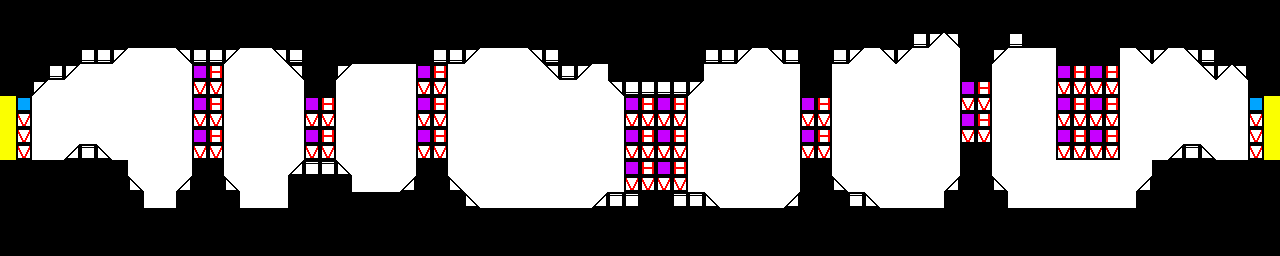

In [20]:
room_viz.room_viz(level, "test.png", "encoding/room_tiles")

In [21]:
from world_rando import room_dtypes

In [22]:
lvl = room_dtypes.Level(Coord(80, 16))
# top and bottom
for x in range(0, lvl.dimensions.x):
    for y in [0,1,14,15]:
        c = Coord(x, y)
        lvl[c] = room_dtypes.mk_default_solid()
# sides
for y in range(0, lvl.dimensions.y):
    for x in [0,1,78,79]:
        c = Coord(x, y)
        lvl[c] = room_dtypes.mk_default_solid()
# fill the interior
lvl.missing_defaults(room_dtypes.mk_default_air)

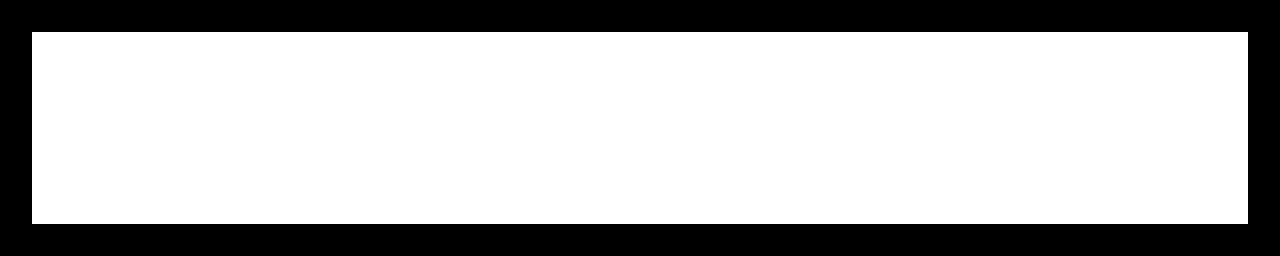

In [23]:
room_viz.room_viz(lvl, "test.png", "encoding/room_tiles")

In [24]:
# Get the compressed bytes representation
new_data = lvl.to_bytes()

In [25]:
new_data_compressed = compress.greedy_compress(new_data)

In [26]:
ndd = decompress.decompress(new_data_compressed)
assert ndd == new_data

In [28]:
# Write it to the ROM
rom_m.write_to_new(level_addr, new_data_compressed + b"\x00\x00")

In [31]:
rom_m.save_rom()